rewrite a ann_text which return dep_list I can direct put into graph

In [1]:
import spacy
import neuralcoref
from spacy import displacy # https://spacy.io/usage/visualizers
def show_depparse(text):
    doc = nlp(text)
    displacy.render(doc, style='dep',jupyter=True)

nlp = spacy.load("en")

### my_dep

#### remove_pronoun

In [2]:
def remove_pronoun(input_t): # replace pronoun with original noun
    neuralcoref.add_to_pipe(nlp)
    doc = nlp(input_t)
    cvt_dict = dict()
    for s in doc._.coref_clusters: # find pronouns save it as dict
        cvt_dict[str(s.main)] = [str(i) for i in s.mentions if i != s.main]
#    print("pronoun dict:", cvt_dict)
    nlp.remove_pipe("neuralcoref")
    
    pn_list = [] # save list as (pronoun, origin noun)
    for pn_main in cvt_dict:
        for pn in cvt_dict[pn_main]:
            pn_list.append( (pn, pn_main) )
    rm_dup_pronouns(pn_list)
#    print("pronoun list without dup:", pn_list)
    
    no_pronoun_t = [] # replace pronoun with origin noun
    for tok in doc:
        if tok.lemma_ == "-PRON-":
            replace_pronoun = False
            for pn_idx, pn in enumerate(pn_list):
                if tok.text == pn[0]:
                    replace_pronoun = True
                    no_pronoun_t.append(pn[1])
                    del(pn_list[pn_idx])
            if pn_list is None or replace_pronoun is False:
                no_pronoun_t.append(tok.text)
        else:
            no_pronoun_t.append(tok.text)
    new_t = " ".join(no_pronoun_t)

    return new_t

def rm_dup_pronouns(pn_list):
    rm_idx_list = []
    for idx, i in enumerate(pn_list):
        if i[0] == i[1]:
            rm_idx_list.append(idx)
    rm_idx_list.reverse()
    for rm_idx in rm_idx_list:
        del pn_list[rm_idx]
    # # example
    # pn_list = [('his', 'Lo Shang-hua (羅尚樺)'),("it","it"), ("the","the"), ('he', 'Lo Shang-hua (羅尚樺)'), ('Lo', 'Lo Shang-hua (羅尚樺)'), ('his aircraft', 'his aircraft'), ('his', 'Pan’s'), ('He', 'Pan’s'), ('his', 'Pan’s'), ('it', 'The Taitung District Prosecutors’ Office'), ('its', 'The Taitung District Prosecutors’ Office')]
    # rm_dup_pronouns(pn_list)
    # pn_list
    
t = 'Angela lives in Boston. She is quite happy in that city. She enjoy her life.'
#t = "He is nice."
remove_pronoun(t)

'Angela lives in Boston . Angela is quite happy in that city . Angela enjoy Angela life .'

#### dep_create

##### ann_text (dep relation format)

In [3]:
def ann_text(text, all_dep=False):
    no_pronoun_text = remove_pronoun(text)
    doc = nlp(no_pronoun_text)
    
    dep_list = []
    for sent_idx, sent in enumerate(doc.sents):
        for tok_idx, tok in enumerate(sent):
            dep = find_dep(tok, all_dep)
            if dep is not None:
                dep_list.extend( dep )
#         print("===== next semt =====")
    return dep_list

def dep_fwfw(tok, dp1, dp2, double_dir=False, reverse=False): # dep_forward_forward
    # A->B->C  => C->A
    #     ex: table for food
    #         dep = (table-->for), (for-->food)
    #             => table<--food
    source = None
    target = None
    for child in tok.children:
        if child.dep_ == dp1:
            for cchild in child.children:
                if cchild.dep_ == dp2:
                    source = tok
                    target = cchild
    return creat_dep(source, target, double_dir, reverse)

def dep_side(tok, dp1, dp2, double_dir=False, reverse=False):
    # A<-B->C => C->A
    #     ex: He is nice.   dep = (is->he), (is->nice) 
    #                           => nice->he
    source = None
    target = None
    for child in tok.children:
        if child.dep_ == dp1:
            target = child
        if child.dep_ == dp2:
            source = child
    return creat_dep(source, target, double_dir, reverse)

# def dep_chg(tok, dp, double_dir=False, reverse=True): # dep_change
#     # A->B => B->A
#     #     ex: poor cat     dep = (cat->poor)
#     #                          => poor->cat
#     source = None
#     target = None
#     for child in tok.children:
#         if child.dep_ == dp:
#             source = child
#             target = tok
#     return creat_dep(source, target, double_dir, reverse)

def dep_rem(tok, dp, double_dir=False, reverse=False): # dep_remain
    # A->B => A->B
    #     ex: find->it     dep = (find->it)
    #                          => find->it
    source = None
    target = None
    for child in tok.children:
        if child.dep_ == dp:
            source = tok
            target = child
    return creat_dep(source, target, double_dir, reverse)
    
    
def creat_dep(source, target, double_dir=False, reverse=False):
    if source is not None and target is not None:
        if double_dir:
            return [( tok2node(source), tok2node(target) ), 
                    ( tok2node(target), tok2node(source) )]
        else:
            if reverse: # source -> target
                return (tok2node(target), tok2node(source) )
            else:
                return (tok2node(source), tok2node(target) )
    else:
        return None
def tok2node(token): # token => str( lemma=pos )
    tok_lemma = token.lemma_
    if token.lemma_ == "-PRON-":
        tok_lemma = token.text.lower()
    if token.pos_ == "PUNCT":
        return token.text
    else:
        return "".join([tok_lemma, '=', token.pos_])


##### find_dep

In [4]:
def find_dep(tok, all_dep=False):
    tmp_dep_list = []
    if all_dep:
        tmp_dep_list.append( deps(tok))
    else:
        tmp_dep_list.append( nsubj(tok) )
        tmp_dep_list.append( nsubjp(tok))
        tmp_dep_list.append( same(tok)  )
        tmp_dep_list.append( ppobj(tok) )
        tmp_dep_list.append( agpbj(tok) )
        tmp_dep_list.append( dative(tok))
        tmp_dep_list.append( ppcomp(tok))
        tmp_dep_list.append( advcl(tok) )
        tmp_dep_list.append(npadvmod(tok))
        tmp_dep_list.append( amod(tok)  )
        tmp_dep_list.append( advmod(tok))
        tmp_dep_list.append( dobj(tok)  )
        tmp_dep_list.append( nummod(tok))
        tmp_dep_list.append( xcomp(tok) )
        tmp_dep_list.append( ccomp(tok) )
        tmp_dep_list.append( acl(tok)   )
        tmp_dep_list.append( poss(tok)  )
        tmp_dep_list.append( relcl(tok) )
        tmp_dep_list.append( oprd(tok)  )
        tmp_dep_list.append(compound(tok))
    return flat_rmNone_list(tmp_dep_list)

def flat_rmNone_list(tmp_dep_list):
    dep_list = []
    for dep in tmp_dep_list:
        if dep is None:
            continue
        elif type(dep) is list:
            dep_list.extend(dep)
        else:
            dep_list.append(dep)
    return dep_list

def deps(tok):
    source = None
    target = None
    dep_list = []
    for child in tok.children:
        source = tok
        target = child
        dep_list.append(creat_dep(source, target))
    return flat_rmNone_list(dep_list)

def nsubj(tok):
    dep = dep_side(tok, 'nsubj', 'acomp') # "I am nice"
    if dep is None:
        dep = dep_side(tok, 'nsubj', 'attr', double_dir=True)  #"Tom is man"
    if dep is None:
        dep = dep_rem(tok, 'nsubj') # "I ran home"
    return dep
def nsubjp(tok):
    return dep_rem(tok, 'nsubjpass') # "dog was found"
def same(tok):
    return dep_rem(tok, 'appos', double_dir=True) # "Sam, the VIP"
def agpbj(tok): # agent+pobj
    return dep_fwfw(tok, 'agent', 'pobj') # "taken by us"
def ppobj(tok): # prep+pobj
    if tok.pos_ in ['NOUN', 'PROPN']: 
        return dep_fwfw(tok, 'prep', 'pobj', reverse=True) # "table of picnic"
    else:                             
        return dep_fwfw(tok, 'prep', 'pobj') # "some of toys"
def dative(tok):
    return dep_rem(tok, 'dative') # "gave me book"
def ppcomp(tok):
    return dep_fwfw(tok, 'prep', 'pcomp') # "play at flying"
def advcl(tok):
    return dep_rem(tok, 'advcl') #"cry when fail"
def npadvmod(tok):
    return dep_rem(tok, 'npadvmod', reverse=False) # "done this morning"
def amod(tok):
    return dep_rem(tok, 'amod', reverse=True) # "poor student"
def advmod(tok):
    return dep_rem(tok, 'advmod', reverse=True) # "less often"
def dobj(tok):
    return dep_rem(tok, 'dobj') # "find it"
def nummod(tok):
    return dep_rem(tok, 'nummod', reverse=True) # "ten books"
def xcomp(tok):
    return dep_rem(tok, "xcomp") # "easy to play"
def ccomp(tok):
    return dep_rem(tok, "ccomp") # "I conside him fool"
def poss(tok):
    return dep_rem(tok, "poss", reverse=True) # "his gun"
def relcl(tok):
    return dep_rem(tok, "relcl", reverse=True) # "girl who likes me"
def oprd(tok):
    return dep_rem(tok, "oprd") # "made public"
def acl(tok):
    return dep_rem(tok, "acl", reverse=True) # "fact that nobody care"
def compound(tok):
    return dep_rem(tok, "compound", double_dir=True)

t = "Robin Kuo Chin Ting"
ann_text(t, all_dep=True)

[('Kuo=PROPN', 'Robin=PROPN'),
 ('Chin=PROPN', 'Kuo=PROPN'),
 ('Ting=PROPN', 'Chin=PROPN')]

In [5]:
t = "Chin Ting, Kuo"
show_depparse(t)

### calculate keyword weight

In [6]:
import networkx as nx 
import matplotlib.pyplot as plt 
def get_keyphrase_weight(text, direct=True, in_edge=True, show_graph=False, all_dep=False, div_wcnt=False):
    
    dep_list = ann_text(text, all_dep)

    if direct:
        G = nx.DiGraph()
    else:
        G = nx.MultiGraph() 
    for i in dep_list: # [('cool=JJ', 'he=NN', 'nsubj')]
        G.add_edge(i[0], i[1]) 
    if show_graph:
        nx.draw_networkx(G, with_label = True, node_color="yellow")
    
    # ======= calculate weight ======= 
    # count how many edge attach to each node
    node_edge_cnt_dict = dict()
    for node in G.nodes:
        if direct==True and in_edge==True:
            node_edge_cnt_dict[node] = len(G.in_edges(node))
        else: # out_edge
            node_edge_cnt_dict[node] = len(G.edges(node))

    # count how many times a word had appear
    node_word_cnt_dict = word_freq_cnt(dep_list)


    weight_node_dict = dict()
    for node in node_edge_cnt_dict.keys():
        if div_wcnt:
            weight_node_dict[node] = node_edge_cnt_dict[node] /node_word_cnt_dict[node]
        else:
            weight_node_dict[node] = node_edge_cnt_dict[node]
        #print(node , node_edge_cnt_dict[node] , "/", node_word_cnt_dict[node], "=", weight_node_dict[node])
    sorted_weight_node_dict = dict(sorted(weight_node_dict.items(), key=lambda k: k[1], reverse=True))
    return sorted_weight_node_dict

def word_freq_cnt(dep_list):
    freq_dict = {}
    for node_s, node_t in dep_list:
        if node_t not in freq_dict:
            freq_dict[node_t] = 1
        else:
            freq_dict[node_t] += 1
    return freq_dict

### example
#get_keyphrase_weight(new)
tex = "Robin Kuo is walking away from the house. The house is very scary."
get_keyphrase_weight(tex, direct=True, in_edge=True, show_graph=True, all_dep=False, div_wcnt=False)

/Users/dragonfly/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/dragonfly/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


{'Kuo=PROPN': 2,
 'house=NOUN': 2,
 'Robin=PROPN': 1,
 'walk=VERB': 1,
 'scary=ADJ': 1,
 'away=ADV': 0,
 'very=ADV': 0}

### news

In [7]:
news1 = {
    "title": "Typhoon Surigae might bring rain, CWB says",
    "source": "https://www.taipeitimes.com/News/taiwan/archives/2021/04/19/2003755957",
    "content": '''
Typhoon Surigae is to bring rain to the nation’s east coast and mountainous areas in central and southern Taiwan from Wednesday to Friday, the Central Weather Bureau (CWB) said yesterday.
As of 2pm yesterday, the typhoon’s center was 1,170km southeast of Oluanpi (鵝鑾鼻), Taiwan’s southernmost tip. The radius of the storm was 280km, and it was moving northwest at 9kph, with a maximum wind speed of 198kph.
The bureau forecasts that the storm would switch to a northerly direction when approaching the east coast of Luzon Island in the Philippines on Wednesday, CWB forecaster Lin Ding-yi (林定宜) said, adding that Surigae would then move northeast along the Bashi Channel.
Chances of temporary showers would be high in Yilan, Hualien and Taitung counties, as well as in the mountainous areas of central and southern Taiwan, he said.
Surigae was to maintain its strength yesterday and today, Lin said, adding that similarly strong typhoons in April occurred in 1997, 2003 and 2015.
Typhoons usually occur from July to September, the bureau said.
Residents on the northern, eastern and southern coasts as well as those in Penghu and Kinmen counties should be prepared for swells, Lin said.
Peng Chi-ming (彭啟明), chief executive of WeatherRisk Explore Inc, yesterday wrote on Facebook that Surigae was at the peak of its strength, with lightning frequently occurring at its eye and convection at its circumfluence.
If it made landfall at this strength, it might cause a major disaster, he said.
However, it was a good sign that convective heat transfer in mountainous areas began to occur yesterday afternoon, Peng said.
“Convective heat transfer usually occurs on the west coast in April, but this year, it did not occur until yesterday,” he said.
Thermal instability in the mountains of southern Taiwan were influenced by the typhoon, he added.
CWB Director-General Cheng Ming-dean (鄭明典) said that Surigae has a double eyewall, which is generally a feature of strong typhoons, indicating that the storm might grow further before reaching Luzon.
However, Surigae would gradually weaken once it is moving away from Luzon, Cheng said, citing conditions unfavorable for the typhoon.
WeatherRisk analyst Wu Sheng-yu (吳聖宇) wrote on Facebook that Surigae would likely remain east of the Philippines for at least three to four days, and then accelerate its northward motion.
“When the westerly trough abates, Surigae could also bring rain from southeast China. This might be the best opportunity we have for rain since the beginning of this month. If rain does not occur this time, we might have to wait for next month,” Wu said.
Meanwhile, poor air quality was early yesterday recorded in the outlying island counties of Kinmen and Penghu, and parts of western Taiwan due to pollutants from China and stagnant winds, the Environmental Protection Administration said.
At 9am, 20 air monitoring stations in areas north of Hsinchu County and in Penghu and Kinmen detected generally unhealthy air quality at the “red alert” level, the agency said.
'''}
news2 = {
    "title": "Ministry raises restrictions to conserve water",
    "source": "source: https://www.taipeitimes.com/News/front/archives/2021/04/17/2003755843",
    "content":'''
The Ministry of Economic Affairs is to tighten water restrictions to prevent Taiwan from running out of water before the rainy season starts next month, the ministry said yesterday.
Hsinchu County remains on “orange alert,” although industrial users that consume more than 1,000m2 of water per day have been asked to reduce consumption by 13 percent, up from the previously required 11 percent, it said, adding that Kaohsiung and Tainan industrial users would have to reduce consumption by 11 percent, up from 7 percent.
Non-industrial large water users would have to reduce water consumption by 20 percent, up from 10 percent, it added.
In Taoyuan, water pressure for households is to be reduced all day, in extension to the current nighttime reduction.
“As the water shortage extends, there are only three things we can do: conserve, reallocate and find new sources of water,” Minister of Economic Affairs Wang Mei-hua (王美花) told reporters at the Central Emergency Operation Center dedicated to the nation’s water situation.
Taichung and Miaoli County, which face the strongest effects of the shortage, are on “red alert,” and water supply in the area is switched off on two days per week.
The measure has helped save about 15 percent of water, Wang said.
The alert level in Hsinchu would not be upgraded to red, she said, adding that no water outages were planned.
Pipelines supplying water from less affected regions have been instrumental in mitigating the situation, Wang said.
“The Taoyuan-Hsinchu pipeline is delivering 225,000 tonnes of water per day, with 10,000 of that going on to Miaoli,” Wang said. “A further 100,000 tonnes a day are delivered from Yunlin County to Chiayi County, and 50,000 tonnes are delivered from Tainan to Kaohsiung.”
New wells are also being drilled at a breakneck pace, with all available CPC Corp, Taiwan (台灣中油) engineers being employed by the ministry, she said.
“At two sites near Taichung, engineers struck ground water,” Wang said. “We are expediting the installation of filters and the certification of the well.”
The two wells might provide up to 48,000 tonnes per day, enough for 200,000 people, she added.
Nationwide, 88 emergency wells would be dug, adding to the 25 existing emergency wells, she said.
The wells would provide up to 115,000 tonnes as early as at the end of this month, enough to supply 500,000 people, she added
Engineers are drilling three wells in Miaoli County’s Liyutan (鯉魚潭), which would provide 15,000 tonnes per day, she said.
“We compressed months of work into weeks to find new water resources,” Wang said.
Asked whether the water level at the Shimen Reservoir (石門水庫), which supplies the Taoyuan-Hsinchu pipeline, might fall to below 30 percent, Wang said that the level is above expectations.
“In February and March, we were expecting the level to be lower than it is now,” Wang said. “We are trying to find alternate sources to make sure that the level remains as high as possible.”
'''}
news3 = {
    "title": "Dozens change name to ‘salmon’",
    "source": "source: https://www.taipeitimes.com/News/taiwan/archives/2021/03/18/2003754047",
    "content":'''
Household registration offices nationwide have since Tuesday been flooded with people applying to change their name to “salmon” (guiyu, 鮭魚), after Japanese sushi restaurant chain Akindo Sushiro promised free meals for anyone with the name.
Yesterday and today, those with proof of the unusual moniker can receive free meals for their entire table, while people with homophonic names can enjoy half price and those with at least one homophonic character can receive 10 percent off.
Twenty-eight people had claimed free meals as of 3pm yesterday, while at least 1,000 people had participated in the promotion, Akindo Sushiro said.
An applicant must pay NT$80 for a new identification card and household registration certificate, the Taipei Department of Civil Affairs said, adding that at least 20 people had applied by early afternoon.
As of late afternoon, New Taipei City and Kaohsiung had 26 people who changed their name to “salmon,” while Taichung had 22, and Tainan and Taoyuan each had 14.
In Taichung, a college student surnamed Kuo (郭) changed her name to Kuo “Salmon Rice Bowl” (郭鮭魚丼飯) to treat her friends, but told reporters that she plans to change it back tomorrow.
Two others managed to eat NT$13,000 worth of sushi in one sitting with their friends, saying online: “I do not think we will want to eat salmon again for a while.”
Another participant set a new record for longest name at 36 characters, already dethroning the previous titleholder, a Tainan-based taxi driver who applied for his 25-character name on Feb. 26.
The name translates to “Chen loves Taiwan, abalone, tuna, salmon, snow crab, sea urchin, scallop, lobster and beef, Mayfull, Palais de Chine, Regent, Hilton, Caesar Park, Hotel Royal.”
While people are free to choose their own name, the Ministry of the Interior urged caution, as it can only be legally changed three times.
A man surnamed Hsu (許) learned this the hard way after his mother informed him that she had already changed his name twice when he was a child.
Screenshots of Hsu’s Line messages went viral on the Professional Technology Temple bulletin board, eliciting sympathy and skepticism among those who said that the office would have informed him that it was his last change.
“Each person has three chances to change their name,” the ministry wrote on Facebook. “Everyone, please consider your name carefully.”
'''}
news4 = {
    "title": "‘Megaship’ in Suez Canal nearly free",
    "source": "source: https://www.taipeitimes.com/News/front/archives/2021/03/25/2003754453",
    "content": '''
Progress made moving a container ship blocking the Suez Canal should allow some traffic to resume today, while Evergreen Marine Corp (長榮海運) said that it leased the vessel, but would refuse to pay if it remained stuck.
The MV Ever Given — a so-called “megaship” at 220,000 tonnes and 400m long — which ran aground in the southern part of the canal in Egypt, had been partially moved and is alongside the bank, said Ahmed Mekawy, deputy manager of the Suez Canal for GAC Group, a provider of port-agent services.
The vessel was soon expected to be refloated, Mekawy said, adding that the Suez Canal Authority would then work on resuming transit for all waiting ships.
The canal authority had yet to comment on whether the vessel had been moved.
Evergreen, which chartered Ever Given from Luster Maritime SA, was notified by the ship owner that the vessel deviated from its course due to suspected sudden strong wind and ran aground 6 nautical miles (11km) south of the estuary at 8am on Tuesday, it said in a statement yesterday.
Evergreen urged the ship owner to report the cause of the incident and set up a plan with the authorities to get the vessel out of trouble as soon as possible, it said.
Evergreen said that it rented the vessel under a time charter arrangement to add cargo capacity to its operations from East Asia to Europe, while the crew was appointed by the ship owner.
“We rent the vessel and decide which seaports it will go to for our sea cargo business. If the Ever Given is still aground and cannot operate normally, we will not pay the rent,” a company official told the Taipei Times by telephone.
Whether Evergreen would seek compensation from the ship owner would depend on the cause of the incident, and it would make the decision after an investigation is completed, it added.
Luster Maritime, which is headquartered in Panama and a unit of Japan’s Shoei Kisen Kaisha Ltd, provides sea freight transportation services.
The incident left dozens of ships gridlocked as they attempted to transit between the Red Sea and the Mediterranean.
Efforts to free the ship had so far proceeded faster than initial warnings that traffic could be choked off for days.
The 193km-long Suez Canal is among the most trafficked waterways in the world, used by tankers shipping crude from the Middle East to Europe and North America.
About 12 percent of global trade and 8 percent of liquefied natural gas pass through the canal, as do about 1 million barrels of oil per day.
The Ever Given was grounded early on Tuesday amid poor visibility caused by a dust storm and wind speeds that reached 40 knots, resulting in a “loss of the ability to steer the ship,” the canal authority said.
About 42 vessels either in the northbound convoy or arriving to transit the canal in that direction were waiting for the Ever Given to be refloated, Leth Agencies, one of the top providers of Suez Canal crossing services, said in a notice to clients.
The company said that it was sending a dredger to help free the ship.
About 64 vessels traveling southbound were also affected.
GAC said that 15 affected ships were waiting at anchorage.
'''
}
news5 = {
    "title": "Ko Wen-je says Taipei’s street names need change",
    "source": "https://www.taipeitimes.com/News/taiwan/archives/2021/04/21/2003756086",
    "content": '''
Taipei’s street names should reflect a “Taiwanese spirit,” Taipei Mayor Ko Wen-je (柯文哲) said in an online video released yesterday, in which he asked why many of them are named after locations in China.
In a three-minute video uploaded to a Facebook page called “Taiwanese Uncle Ko Wen-je” (台灣阿北柯文哲), the mayor suggested changing the names of Taipei streets.
The page’s banner was a photograph of Ko on Jade Mountain’s (玉山) main peak.
The page was closed at about noon, about four hours after it was made public.
Ko said that street names in the capital named “Ningxia,” “Tibet,” “Beiping” — an old name for Beijing — “Tianjin” and “Changan” make walking them a disconcerting experience, as they are names of provinces or cities in China.
“For Taiwanese who grew up on this piece of land, it is really confusing that the street names refer to Chinese cities,” he said.
“They are a trace of history, not names from Taiwan,” he said.
“I think it is strange that the headquarters of a political party that claims to be the ‘most local’ is on Beiping E Road,” he said, an apparent reference to the Democratic Progressive Party (DPP).
“You must agree that it is strange,” he said.
Changing street names is important, so perhaps a “street name rectification” platform would allow people from across political lines to discuss the issue and propose names that represent the “Taiwanese spirit,” he said.
Then Taipei residents would have street names that represent them better, Ko said.
When asked about the page, Ko said that “it was established by a friend.”
Taipei City Government deputy spokesperson Wei Yu-jen (魏佑任) said that the page was not set up by the city government, nor by the Taiwan People’s Party, of which Ko is the chairman.
It might have been established by a supporter, Wei said, adding that he did not know when the video was filmed.
'''
}
news6 = {
    "title": "COVID-19: Number of infected pilots rises to nine",
    "source": "https://www.taipeitimes.com/News/front/archives/2021/04/27/2003756412",
    "content": '''
The total number of China Airlines (CAL, 華航) cargo pilots diagnosed with COVID-19 rose to nine yesterday, after the Central Epidemic Command Center (CECC) said two more pilots were confirmed with the virus.
The center has not identified a link among the nine cases or a clear sign of a transmission chain among the airline’s pilots, given the tests results so far and that the nine pilots are from four different fleets, said Minister of Health and Welfare Chen Shih-chung (陳時中), who heads the center.
The sources of infection might be better understood after analyzing the polymerase chain reaction (PCR) and antibody test results of all CAL pilots, Chen said.
The center has asked the airline to provide surveillance footage from the overseas hotels where the infected pilots stayed during their layovers.
Special police and healthcare experts from centralized quarantine centers would also be dispatched to the airline’s quarantine facility in Taiwan to help determine whether disease prevention measures at the facility are adequate, he said.
Before yesterday, the center had reported seven confirmed cases of COVID-19 in CAL cargo pilots in as many days, including an Indonesian pilot who tested positive in Australia.
The center had launched an expanded testing program to screen all 1,272 of CAL’s pilots.
One of the two new cases — No. 1,102 — is a Taiwanese man who flew to the US on April 6 and returned on April 9, Chen said, adding that he tested negative on April 14 after completing quarantine in Taiwan.
He flew on another trip to the US from Monday and Thursday last week.
He developed a cough and a fever on Saturday, and tested positive on Sunday with a high viral load, indicating a recent infection, he said.
Chen said the other new case — No. 1,105 — is a Taiwanese man who flew to the US on April 8 and returned on April 10.
He tested negative upon completing quarantine in Taiwan on April 15, Chen said.
He was tested again on Sunday in the expanded testing program and the result came back positive, he said.
The pilot said he lost his appetite on Monday last week, he added.
The sources of infection are being investigated, Chen said.
Although case No. 1,102 attended a public event in Taiwan on April 16, the center believes that the risk of him infecting others at the event is low, because he had tested negative on April 14, Chen said.
People with COVID-19 usually become contagious three days before symptoms begin, and as the pilot developed symptoms on Saturday, he is more likely to have been in the US or under quarantine in Taiwan when he was contagious, Chen said.
The CECC also reported two new imported cases — a Burmese man and a Chinese man who are crew members on the same ship.
Separately yesterday, reporters asked whether inbound travelers who have received the full dosage of a COVID-19 vaccine in another country would be exempt from quarantine upon arrival.
Chen said a trial program, which is in its final approval process, would soon be launched.
The center might allow a limited number of people who have been vaccinated for at least a month to apply for a reduced quarantine period of seven days, starting in the middle of next month, he said.
The vaccines would need to be complemented with a negative PCR test result obtained before arriving in Taiwan, an antibody test taken upon arrival and another negative PCR test result on the last day of quarantine, he said.
The center on April 14 announced that crew members from Taiwanese airlines who have been vaccinated for at least two weeks would be exempt from mandatory home quarantine after returning to the nation, and would only have to perform seven days of self-health management after a long-haul flight.'''
}

news7 = {
    "title": "One pilot dead, another missing after jets collide",
    "source": "https://www.taipeitimes.com/News/front/archives/2021/03/23/2003754316",
    "content": '''
The nation yesterday grounded its entire fleet of F-5 jets after two disappeared over the ocean in the afternoon.
Citing information from the Ministry of National Defense, the National Rescue Command Center said that four F-5Es took off from Taitung Airbase at 2:30pm for a routine training mission before two of the jets disappeared from radar screens 1.4 nautical miles (2.6km) east of Pingtung’s Mudan Township (牡丹), apparently after a mid-air collision, at about 3:06pm.
As of press time last night, rescuers were searching for captain Pan Ying-chun (潘穎諄), one of the pilots.
Lieutenant Lo Shang-hua (羅尚樺), the pilot of the other plane, was found unconscious at sea at about 4pm and rushed to hospital. He later died of his injuries.
The nation manufactured 242 single-seat F-5s and 66 two-seater F-5s under license from Northrop Corp between 1973 and the mid-1980s.
An F-5 jet crashed and its pilot was killed during a training exercise east of Taiwan in October last year.
The pilot, who had ejected and was rescued, later died despite hours of emergency treatment.
In November, an F-16 was lost off the east coast minutes after taking off from a base in Hualien.
In October last year, sources said that the military plans to retire its F-5 jets in 2026, when the US completes delivery of 66 F-16Vs.
'''
}

news8 = {
    "title": "China debuts train prototype that can hit speeds of 620 kilometers per hour",
    "source": "https://edition.cnn.com/travel/article/china-high-speed-maglev-train-intl-hnk/index.html",
    "content": '''
(CNN) — China has revealed a prototype for a new high-speed Maglev train that is capable of reaching speeds of 620 kilometers (385 miles) per hour.
The train runs on high-temperature superconducting (HTS) power that makes it look as if the train is floating along the magnetized tracks.
The sleek 21-meter-long (69 feet) prototype was unveiled to media in the city of Chengdu, Sichuan Province, on January 13. In addition, university researchers constructed 165 meters (541 feet) of track to demonstrate how the train would look and feel in transit, according to state-run Xinhua News.
Professor He Chuan (vice president of Southwest Jiaotong University, which worked on the prototype) told reporters that the train could be "operational" within 3-10 years.
He added: "Sichuan has rich rare earth resources, which is very beneficial to our construction of permanent magnet tracks, thus promoting the faster development of experiments."
China is home to the world's largest high-speed rail network, which stretches over 37,000 kilometers, and the fastest commercially operating train -- the Shanghai maglev.
The country's first high-speed Maglev train, it began operating in 2003. Running at a top speed of 431 kph, the train links Shanghai Pudong Airport and Longyang Road in the eastern side of Shanghai.
China has been eager to make further infrastructure improvements ahead of the 2022 Winter Olympics, which will take place in Beijing.
This time last year, China unveiled a new 174-kilometer high-speed railway line connecting Beijing with 2022 Winter Olympics host city Zhangjiakou, cutting the travel time between the two from three hours to 47 minutes.
Earlier this month, the country debuted a bullet train specifically designed to withstand freezing temperatures. The CR400AF-G train can travel up to 350 kilometers per hour in weather as cold as -40 degrees Celsius (-40 degrees Fahrenheit).
It will run on routes between Beijing, Shenyang and Harbin -- the latter of which is so cold that it hosts an annual snow and ice festival.
'''
}

news9 = {
    "title": "Mars helicopter shares first aerial color photo and preps for Sunday flight",
    "source": "https://edition.cnn.com/2021/04/23/world/mars-helicopter-color-image-third-flight-scn/index.html",
    "content": '''
(CNN)So this is what the view looks like when flying on Mars.
The Ingenuity helicopter captured its first color image from 17 feet (5.2 meters) above the Martian surface during its second flight on April 22. And now, it's preparing for a third flight, scheduled for Sunday.
Ingenuity autonomously flew for almost 52 seconds during its second flight, climbing 16 feet (4.9 meters) up through the Martian atmosphere. After a brief hover, it tilted at a 5-degree angle and moved sideways for 7 feet (2.1 meters).
The helicopter hovered in place again to make three turns. This allowed Ingenuity's color camera to capture images taken looking in different directions, before the chopper touched back down in the center of the airfield. Ingenuity only collected black-and-white images with its navigation camera during the first flight on April 19.
The color image, shared on Friday by NASA, is the first taken by an aerial vehicle while aloft on Mars. On either side of the image, landings pads from two of the helicopter's four legs can be seen.
The helicopter's shadow on the surface of Mars can be seen at the bottom of the image.
The view from the helicopter's perspective reveals tracks made by the Perseverance rover when it initially had deposited the helicopter in the middle of its 33-foot-by-33-foot (10-meter-by-10-meter) airfield, now known as Wright Brothers Field.
There is also a glimpse of the Martian horizon in the upper-right and left corners of the photo.
The helicopter team believes this image helps demonstrate the unique aerial scouting ability of Ingenuity and other rotorcraft that could be modeled after it in the future.
'''
}

news10 = {
    "title": "SpaceX capsule with four astronauts aboard docks with International Space Station",
    "source": "https://edition.cnn.com/2021/04/24/tech/spacex-nasa-astronaut-crew-2-docking-scn/index.html",
    "content": '''
Austin, Texas (CNN Business)A SpaceX Crew Dragon spacecraft — carrying four astronauts from three countries — docked with the International Space Station early Saturday morning ET, beginning the crew's six-month stay in space.
This mission, dubbed Crew-2, marks the third-ever crewed flight for Elon Musk's company and the first to make use of a previously flown, privately-owned rocket booster and spacecraft.
The astronauts took off from Kennedy Space Center in Florida Friday morning and spent nearly 24 hours soaring through orbit at more than 17,000 miles per hour, as their Crew Dragon spacecraft maneuvered toward the ISS, which orbits about 250 miles above Earth.
On Saturday morning, the capsule slowly aligned itself and moved in to dock directly with one of the space station's ports.
The crew consists of NASA astronauts Shane Kimbrough and Megan McArthur, Thomas Pesquet of the European Space Agency, and Akihiko Hoshide with Japan's JAXA space agency.
A prime focus of the astronauts' mission will be research with "tissue chips," or "small models of human organs containing multiple cell types that behave much the same as they do in the body" and that NASA hopes will advance the development of drugs and vaccines, according to the space agency. That work will build on years of studying biological and other scientific phenomena aboard the ISS, where the microgravity environment can give scientists a better fundamental understanding of how something works.
Kimbrough, McArthur, Pesquet, and Hoshide joined seven astronauts already on board the station, four of whom arrived on a different SpaceX Crew Dragon capsule in November. That brings the space station's current total of personnel to 11 — one of the largest crews the ISS has ever hosted. But that number will quickly drop back down to seven when four of the astronauts who'd been on board hitch a ride home from the station on April 28.
NASA has spent more than a decade working to boost staffing aboard the 21-year-old space station after the retirement of its Space Shuttle program in 2011 left Russia's Soyuz spacecraft as the only option for getting astronauts to and from the ISS. The United States had been paying Russia as much as $90 million per seat for those trips.
For years, SpaceX worked under a $2.6 billion fixed-price contract to develop its Crew Dragon spacecraft under NASA's Commercial Crew program, which for the first time in the space agency's history handed over the task of building and testing a crew-worthy spacecraft to the private sector.
(Boeing (BA) is working under a similar contract to develop its own capsule for the program. That capsule, called Starliner, is still in the testing phase.)
The mission is a hallmark in SpaceX's efforts to reuse spacefaring hardware in order to drive down the cost of spaceflight. Both the Crew Dragon capsule, named "Endeavour," and the Falcon 9 rocket that lofted it into orbit have flown in space before.
Though the company has re-flown boosters and spacecraft dozens of times on satellite and cargo launches over the past several years, this marks the first time the company has reused hardware for a crewed mission.
'''
}

news_list = [news1, news2, news3, news4, news5, news6, news7, news8, news9, news10]

### CODE: cal overlap_score  
require: title_text & keyword_dict

In [22]:
def overlap_score(title_text, keyword_dict, topk=20, show_info=False, show_keywords=False):
    keyword_list = []
    for idx, kw in enumerate(keyword_dict):
        keyword_list.append(kw)
        if idx > topk:
            break
#    print("===== overlap keywords: =====")
    overlap_list = []
    title = preprocess(title_text)
    for k in title:
        if k in keyword_list:
            overlap_list.append(k)
#            print(k, keyword_dict[k])
    score = len(overlap_list) / len(title)
    if  show_info:
        print("=============================")
        print("title:", title)
        print("overlap:", overlap_list)
        print("final_score: {:.2f}".format( score ))
    if show_keywords:
        print("=============================")
        print("==== list topk keywords =====")
        for idx, k in enumerate(keyword_dict):
            print(k , keyword_dict[k])
            if idx > topk: break
    return score



def preprocess(text):
    assert type(text) is str
    stoppath = "./RAKE/SmartStoplist.txt"
    with open (stoppath, 'r') as f:
         stopw = f.read().split("\n")
            
    doc = nlp(text.replace("\n", " "))
    text_list = []
    for tok in doc:
        if tok.pos_ in ["PRON", "PART", "SPACE", "DET", "PUNCT"]:
            continue
        else:
#             if tok.text not in stopw:
                text_list.append(tok.lemma_.lower())
    return text_list

### my_dep overlap_score

In [9]:
def mydep_score(text_list):
    mydep_list = []
    for text in text_list:
        node_dict = get_keyphrase_weight(text, all_dep=False)
        keyword_dict = dict()
        for node in node_dict:
            kw = node.split("=")[0].lower()
            keyword_dict[kw] = node_dict[node]
        mydep_list.append( keyword_dict )
    return mydep_list

In [23]:
content_list = []
for news in news_list:
    content_list.append(news["content"])

title_list = []
for news in news_list:
    title_list.append(news["title"])

mydep_list = mydep_score(content_list)

### TFIDF
total_score = 0
for title, mydep_dict in zip(title_list, mydep_list):
    score = overlap_score(title, mydep_dict, show_info=True)  #topk=20, show_info=False, show_keywords=False):
    total_score += score
    print(score)
print("final_score:", total_score / len(title_list))

title: ['typhoon', 'surigae', 'may', 'bring', 'rain', 'cwb', 'say']
overlap: ['typhoon', 'surigae', 'rain']
final_score: 0.43
0.42857142857142855
title: ['ministry', 'raise', 'restriction', 'conserve', 'water']
overlap: ['ministry', 'water']
final_score: 0.40
0.4
title: ['dozen', 'change', 'name', 'to', 'salmon']
overlap: ['change', 'name', 'salmon']
final_score: 0.60
0.6
title: ['megaship', '’', 'in', 'suez', 'canal', 'nearly', 'free']
overlap: ['megaship', 'canal']
final_score: 0.29
0.2857142857142857
title: ['ko', 'wen', 'je', 'say', 'taipei', '’s', 'street', 'name', 'need', 'change']
overlap: ['je', 'taipei', 'street', 'name']
final_score: 0.40
0.4
title: ['covid-19', 'number', 'of', 'infect', 'pilot', 'rise', 'to', 'nine']
overlap: ['number', 'pilot']
final_score: 0.25
0.25
title: ['one', 'pilot', 'dead', 'miss', 'after', 'jet', 'collide']
overlap: ['pilot', 'jet']
final_score: 0.29
0.2857142857142857
title: ['china', 'debut', 'train', 'prototype', 'can', 'hit', 'speed', 'of', '62

#### find overlap_score with same keyword in title (lowerm lemma remove_stopword)

In [12]:
# find overlap_score with same keyword in title (lowerm lemma remove_stopword)
def overlap_score(topk_keyword, news, show_keywords=False, all_dep=False):
    # get stopwords
    stoppath = "./RAKE/SmartStoplist.txt"
    with open (stoppath, 'r') as f:
        stopw = f.read().split("\n")

    # preprocess title (lower, lemma, stopword)
    title_list = [str(title_word.lemma_).lower() for title_word in nlp(news["title"]) if str(title_word) not in stopw]

    # save topk=20 keywords
    keyword_list = []
    keyword_dict = get_keyphrase_weight(news['content'], direct=True, in_edge=True, show_graph=False, all_dep=all_dep)
    for idx, kw in enumerate(keyword_dict):
        keyword_list.append(kw.split("=")[0].lower())
        if idx > topk_keyword:
            break

    # find overlap words
    overlap_words = []
    for title_word in title_list:
        if title_word in keyword_list:
            overlap_words.append(title_word)
    print("title:", title_list)
    print("overlap_words: ", overlap_words)
    print("overlap_score: ", len(overlap_words) / len(title_list))
    if show_keywords:
        print("=============================")
        print("==== list topk keywords =====")
        for idx, k in enumerate(keyword_dict):
            print(k , keyword_dict[k])
            if idx > topk_keyword: break
# example
topk_keyword = 20
all_dep=False
show_keywords=False
overlap_score(topk_keyword, news2, 
                  show_keywords=show_keywords, 
                  all_dep=all_dep)

title: ['ministry', 'raise', 'restriction', 'conserve', 'water']
overlap_words:  ['ministry', 'water']
overlap_score:  0.4


### TFIDF overlap_score

#### CODE: tfidf

In [11]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

def sort_dict_by_value(tmp_dict):
    return dict(sorted(tmp_dict.items(), key=lambda k: k[1], reverse=True))

def tfidf_score(text_list):
    clean_text_list = []
    for text in text_list:
        clean_text_list.append( text.replace("\n", " ").lower() )

    # find all unique words
    w_set = set()
    bow_list = []
    for text in clean_text_list:
        bow = text.split(' ')
        bow_list.append(bow)
        w_set = set( w_set.union(set(bow)) )

    wcnt_list = []
    for bow in bow_list:
        wcnt = dict.fromkeys(w_set, 0)
        for word in bow:
            wcnt[word] += 1
        wcnt_list.append(wcnt)

    tf_list = []
    for wcnt, bow in zip(wcnt_list, bow_list):
        tf_list.append( computeTF(wcnt, bow) )

    idfs = computeIDF(wcnt_list)

    tfidf_list = []
    for tf in tf_list:
        tmp_tfidf_dict = computeTFIDF(tf, idfs)
        tfidf_dict = sort_dict_by_value(tmp_tfidf_dict)
        tfidf_list.append( tfidf_dict )
    return tfidf_list

#### print result

In [24]:
content_list = []
for news in news_list:
    content_list.append(news["content"])

title_list = []
for news in news_list:
    title_list.append(news["title"])

tfidf_list = tfidf_score(content_list)
### TFIDF

total_score = 0
for title, tfidf in zip(title_list, tfidf_list):
    score = overlap_score(title, tfidf, show_info=True)  #topk=20, show_info=False, show_keywords=False):
    total_score += score
    print(score) 
print("final_score:", total_score / len(title_list))


title: ['typhoon', 'surigae', 'may', 'bring', 'rain', 'cwb', 'say']
overlap: ['surigae', 'rain']
final_score: 0.29
0.2857142857142857
title: ['ministry', 'raise', 'restriction', 'conserve', 'water']
overlap: ['water']
final_score: 0.20
0.2
title: ['dozen', 'change', 'name', 'to', 'salmon']
overlap: ['change', 'name']
final_score: 0.40
0.4
title: ['megaship', '’', 'in', 'suez', 'canal', 'nearly', 'free']
overlap: ['suez', 'canal']
final_score: 0.29
0.2857142857142857
title: ['ko', 'wen', 'je', 'say', 'taipei', '’s', 'street', 'name', 'need', 'change']
overlap: ['ko', 'taipei', 'street', 'name']
final_score: 0.40
0.4
title: ['covid-19', 'number', 'of', 'infect', 'pilot', 'rise', 'to', 'nine']
overlap: ['covid-19', 'pilot', 'nine']
final_score: 0.38
0.375
title: ['one', 'pilot', 'dead', 'miss', 'after', 'jet', 'collide']
overlap: ['pilot']
final_score: 0.14
0.14285714285714285
title: ['china', 'debut', 'train', 'prototype', 'can', 'hit', 'speed', 'of', '620', 'kilometer', 'per', 'hour']
o

### RAKE overlap score

#### RAKE code

In [13]:
from RAKE.rake import Rake
stoppath = "./RAKE/SmartStoplist.txt"
r = Rake(stoppath)

def rake_score(text_list):
    rake_list = []
    for text in text_list:
        rake_list.append( rake_keyword_dict(text) )
    return rake_list

def rake_keyword_dict(text):
    keyword_dict = dict()
    keyword_list = r.run(text)
    for idx, kyw in enumerate(keyword_list):
        keyword_dict[kyw[0]] = kyw[1]
    return keyword_dict

def rake_overlap_score(title_text, keyword_dict, topk=20, show_info=False, show_keywords=False):
    keyword_list = []
    key_cnt = 0
    for idx, kw in enumerate(keyword_dict):
        if len(kw.split(" ")) == 1:
            keyword_list.append(kw)
            key_cnt += 1
        if key_cnt > topk:
            break
#    print("===== overlap keywords: =====")
    overlap_list = []
    title = preprocess(title_text)
    for k in title:
        if k in keyword_list:
            overlap_list.append(k)
#            print(k, keyword_dict[k])
    score = len(overlap_list) / len(title)
    if  show_info:
        print("=============================")
        print("title:", title)
        print("overlap:", overlap_list)
        print("final_score: {:.2f}".format( score ))
    if show_keywords:
        print("=============================")
        print("==== list topk keywords =====")
        for idx, k in enumerate(keyword_list):
            print(k , keyword_dict[k])
            if idx > topk: break
    return score

/Users/dragonfly/Desktop/keyword_dep/SmartStoplist.txt


#### print result

In [25]:
content_list = []
for news in news_list:
    content_list.append(news["content"])

title_list = []
for news in news_list:
    title_list.append(news["title"])

rake_list = rake_score(content_list)
### TFIDF
total_score = 0
for title, rake in zip(title_list, rake_list):
    score = rake_overlap_score(title, rake, show_info=True) # topk=20, show_info=False, show_keywords=False)
    total_score += score
    print(score)
print("final_score:", total_score / len(title_list))

title: ['typhoon', 'surigae', 'may', 'bring', 'rain', 'cwb', 'say']
overlap: ['typhoon', 'surigae', 'rain', 'cwb']
final_score: 0.57
0.5714285714285714
title: ['ministry', 'raise', 'restriction', 'conserve', 'water']
overlap: ['ministry', 'water']
final_score: 0.40
0.4
title: ['dozen', 'change', 'name', 'to', 'salmon']
overlap: ['change', 'salmon']
final_score: 0.40
0.4
title: ['megaship', '’', 'in', 'suez', 'canal', 'nearly', 'free']
overlap: ['canal']
final_score: 0.14
0.14285714285714285
title: ['ko', 'wen', 'je', 'say', 'taipei', '’s', 'street', 'name', 'need', 'change']
overlap: ['ko', 'taipei']
final_score: 0.20
0.2
title: ['covid-19', 'number', 'of', 'infect', 'pilot', 'rise', 'to', 'nine']
overlap: ['covid-19', 'pilot']
final_score: 0.25
0.25
title: ['one', 'pilot', 'dead', 'miss', 'after', 'jet', 'collide']
overlap: ['pilot']
final_score: 0.14
0.14285714285714285
title: ['china', 'debut', 'train', 'prototype', 'can', 'hit', 'speed', 'of', '620', 'kilometer', 'per', 'hour']
ove

### Note

#### graph note

Total number of nodes:  7
Total number of edges:  6
List of all nodes:  ['2=end', '1=The', '6=command', '4=the', '7=.', '3=of', '5=CPU']
List of all edges:  [('2=end', '1=The'), ('2=end', '6=command'), ('2=end', '7=.'), ('6=command', '4=the'), ('6=command', '3=of'), ('6=command', '5=CPU')]
In-degree for all nodes:  {'2=end': 0, '1=The': 1, '6=command': 1, '4=the': 1, '7=.': 1, '3=of': 1, '5=CPU': 1}
Out degree for all nodes:  {'2=end': 3, '1=The': 0, '6=command': 3, '4=the': 0, '7=.': 0, '3=of': 0, '5=CPU': 0}
Total number of self-loops:  0


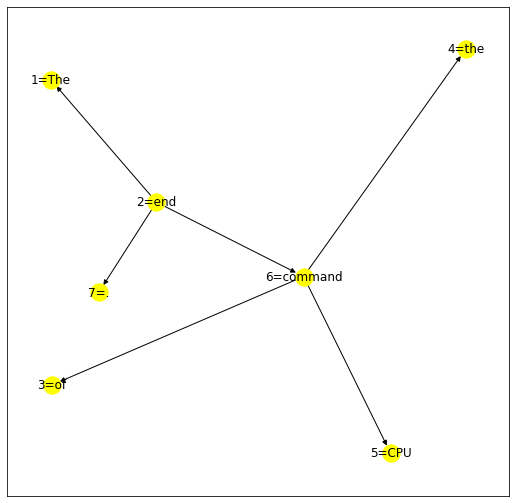

In [233]:
import networkx as nx 
import matplotlib.pyplot as plt

G = nx.DiGraph() 
#nodes_list = [(1,1),(2,2),(3,2)]
nodes_list = [('2=end', '1=The'), ('6=command', '4=the'),('2=end', '6=command'),('2=end', '7=.'),('6=command', '3=of'),('6=command', '5=CPU')]
G.add_edges_from(nodes_list)
  
plt.figure(figsize =(9, 9)) 
nx.draw_networkx(G, with_label = True, node_color ='yellow') 
  
# getting different graph attributes 
print("Total number of nodes: ", int(G.number_of_nodes())) 
print("Total number of edges: ", int(G.number_of_edges())) 
print("List of all nodes: ", list(G.nodes())) 
print("List of all edges: ", list(G.edges())) 
print("In-degree for all nodes: ", dict(G.in_degree())) 
print("Out degree for all nodes: ", dict(G.out_degree)) 
  
print("Total number of self-loops: ", int(G.number_of_selfloops())) 
# print("List of all nodes with self-loops: ", 
#              list(G.nodes_with_selfloops())) 
  
# print("List of all nodes we can go to in a single step from node 2: ", 
#                                                 list(G.successors(2))) 
  
# print("List of all nodes from which we can go to node 2 in a single step: ", 
#                                                     list(G.predecessors(2))) 

#### TFIDF Note

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

documentA = 'the man went out for a walk'
documentB = 'the children sat around the fire'

bagOfWordsA = documentA.split(' ')
bagOfWordsB = documentB.split(' ')
uniqueWords = set(bagOfWordsA).union(set(bagOfWordsB))

numOfWordsA = dict.fromkeys(uniqueWords, 0)
for word in bagOfWordsA:
    numOfWordsA[word] += 1
numOfWordsB = dict.fromkeys(uniqueWords, 0)
for word in bagOfWordsB:
    numOfWordsB[word] += 1


# stoppath = "./RAKE/SmartStoplist.txt"
# with open (stoppath, 'r') as f:
#     stopw = f.read().split("\n")
# # preprocess title (lower, lemma, stopword)
# title_list = [str(title_word.lemma_).lower() for title_word in nlp(news["title"]) if str(title_word) not in stopw]
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

tfA = computeTF(numOfWordsA, bagOfWordsA)
tfB = computeTF(numOfWordsB, bagOfWordsB)

def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

idfs = computeIDF([numOfWordsA, numOfWordsB])

def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

tfidfA = computeTFIDF(tfA, idfs)
tfidfB = computeTFIDF(tfB, idfs)

In [41]:
tfidfA

{'a': 0.09902102579427789,
 'children': 0.0,
 'out': 0.09902102579427789,
 'around': 0.0,
 'fire': 0.0,
 'the': 0.0,
 'for': 0.09902102579427789,
 'sat': 0.0,
 'went': 0.09902102579427789,
 'man': 0.09902102579427789,
 'walk': 0.09902102579427789}

#### RAKE example

In [34]:
from RAKE.rake import Rake
stoppath = "./RAKE/SmartStoplist.txt"
r = Rake(stoppath)
tex = "Robin is walking away from the house. The house is very scary."

r.run(tex)

[('robin', 1.0), ('walking', 1.0), ('house', 1.0), ('scary', 1.0)]